# Application of Machine Learning Methods to Analysis of Cyber-Sport Events
## Dmitry Savostyanov, 131
## Данный скрипт реализует ранжирование игроков по ролям внутри команды на основе вклада в победу, используя информацию на конец матча (важен порядок, но не абсолютные значения показателей).

### TODO: Для роли Carry модель выдает заниженные результаты.
### Role:
###### 1 - Carry
###### 2 - Mid
###### 3 - Hard-lane
###### 4 - Semi-support
###### 5 - Full-support

### Взаимодействие с Dotabuff:
###### Информация об игроке: https://www.dotabuff.com/esports/players/<'account_id'>

###### Информация о матче: https://www.dotabuff.com/matches/<'match_id'>

###### Информация о команде: https://www.dotabuff.com/esports/teams/<'team_id'>

#### В таблице "Matches & Contributions.csv" представлены матчи за период с 03.03.2017 по 30.04.2017

In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import requests
from datetime import datetime
import time
from requests.auth import HTTPBasicAuth
import sys
import io
import datetime
import math 
import sklearn 

# Data Import

In [3]:
sdf_1 = pd.read_csv('ScoresByRole_1.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_2 = pd.read_csv('ScoresByRole_2.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_3 = pd.read_csv('ScoresByRole_3.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_4 = pd.read_csv('ScoresByRole_4.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_5 = pd.read_csv('ScoresByRole_5.0.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })

In [4]:
sdf = pd.concat([sdf_1, sdf_2, sdf_3, sdf_4, sdf_5])

In [5]:
matches = sdf.sort_values(by = ['match_id', 'team_id', 'role'], ascending = False)

In [5]:
# matches

# Cumulative Score (match_id + team_id)

In [6]:
cumprob = matches.groupby(['match_id', 'team_id'], as_index=False)['win_prob'].sum()
cumprob.rename(columns = {'win_prob' : 'cumulative_prob'}, inplace = True)

In [7]:
cumprob.sort_values(by = ['match_id', 'cumulative_prob'], ascending = False, inplace = True)
# cumprob

In [8]:
matches = pd.merge(matches, cumprob, on=['match_id', 'team_id'], how='inner')
matches.rename(columns = {'win_prob_x' : 'win_prob', 'win_prob_y' : 'cumulative_prob'}, inplace = True)

In [9]:
matches['win_contribution'] = matches['win_prob'] / matches['cumulative_prob']

In [10]:
# matches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False)

In [11]:
matchesFreq = matches.groupby(['match_id'])['match_id'].count()

In [12]:
len(matchesFreq)

292

#### Избавимся от матчей, которые представлены менее чем 10 записями

In [13]:
fullMatches = matchesFreq[matchesFreq == 10]
len(fullMatches)

138

In [14]:
isFull = np.in1d(matches['match_id'], fullMatches.index.values)

In [15]:
len(isFull)

2150

In [16]:
matches['isFull'] = isFull

In [17]:
sMatches = matches[matches['isFull'] == True]

# Финальная таблица
## Описание полей:
account_id - Идентификатор игрока

match_id - Идентификатор матча

team_id - Идентификатор команды

role - Исполняемая роль (Описание См. Выше)

datetime - Дата окончания матча

win - Идентификатор победы (Целевая переменная)

win_prob - Предсказанная вероятность победы на основе информации по игроку данной роли

prediction - Предсказание со стандартным порогом отсечения (True if win_prob >= 0.5)

isCorrect - Флаг совпадения предсказания с реальностью

cumulative_prob - Сумма вероятностей победы по команде в матче

win_contribution - Вклад игрока данной роли в победу (win_prob / cumulative_prob)

isFull - Флаг того, что для данного match_id в таблице имеется ровно 10 записей (по 5 на команду)

In [18]:
sMatches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False)

,account_id,match_id,team_id,role,datetime,win,win_prob,prediction,isCorrect,cumulative_prob,win_contribution,isFull
1,72312627,3372726385,2163.0,1.0,13.08.2017 03:12:57,True,0.940032,True,True,4.196710,0.223993,True
2,72312627,3372726385,2163.0,1.0,13.08.2017 03:12:57,True,0.928578,True,True,4.196710,0.221263,True
0,72312627,3372726385,2163.0,1.0,13.08.2017 03:12:57,True,0.862335,True,True,4.196710,0.205479,True
4,72312627,3372726385,2163.0,1.0,13.08.2017 03:12:57,True,0.775022,True,True,4.196710,0.184674,True
3,72312627,3372726385,2163.0,1.0,13.08.2017 03:12:57,True,0.690743,True,True,4.196710,0.164592,True
6,82327674,3372726385,1375614.0,1.0,13.08.2017 03:12:57,False,0.773421,True,False,2.483316,0.311447,True
8,82327674,3372726385,1375614.0,1.0,13.08.2017 03:12:57,False,0.522303,True,False,2.483316,0.210325,True
5,82327674,3372726385,1375614.0,1.0,13.08.2017 03:12:57,False,0.475510,False,True,2.483316,0.191482,True
7,82327674,3372726385,1375614.0,1.0,13.08.2017 03:12:57,False,0.466980,False,True,2.483316,0.188047,True
9,82327674,3372726385,1375614.0,1.0,13.08.2017 03:12:57,False,0.245103,False,True,2.483316,0.098700,True


In [19]:
sMatches.to_csv('Matches & Contributions.csv', index = False, na_rep = 'NaN', sep = ';')

# Plots

# EG vs OG
### match: https://www.dotabuff.com/matches/3148721353
### team1: https://www.dotabuff.com/esports/teams/39
### team2: https://www.dotabuff.com/esports/teams/2586976

## EG

,account_id,match_id,team_id,role,datetime,win,win_prob,prediction,isCorrect,cumulative_prob,win_contribution,isFull
130,72312627,3368158118,2163.0,1.0,11.08.2017 01:32:37,True,0.856869,True,True,4.30433,0.199071,True
131,72312627,3368158118,2163.0,1.0,11.08.2017 01:32:37,True,0.999354,True,True,4.30433,0.232174,True
132,72312627,3368158118,2163.0,1.0,11.08.2017 01:32:37,True,0.996988,True,True,4.30433,0.231624,True
133,72312627,3368158118,2163.0,1.0,11.08.2017 01:32:37,True,0.538835,True,True,4.30433,0.125184,True
134,72312627,3368158118,2163.0,1.0,11.08.2017 01:32:37,True,0.912284,True,True,4.30433,0.211946,True


<IPython.core.display.Javascript object>


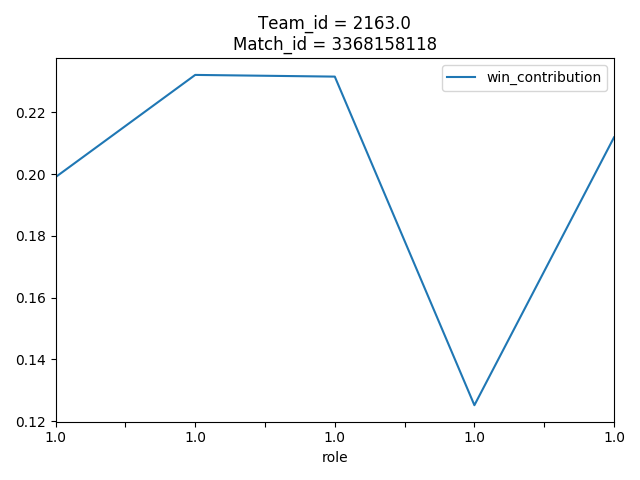

In [28]:
match_id = '3368158118'
team_id = '2163.0'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
display(example)
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
# picTitle='VP'
plot = example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)
fig = plot.get_figure()
plt.tight_layout()
fig.savefig(str(example.iloc[0,1]) + "_" + str(example.iloc[0,2]) + ".png", dpi = 400)

## OG

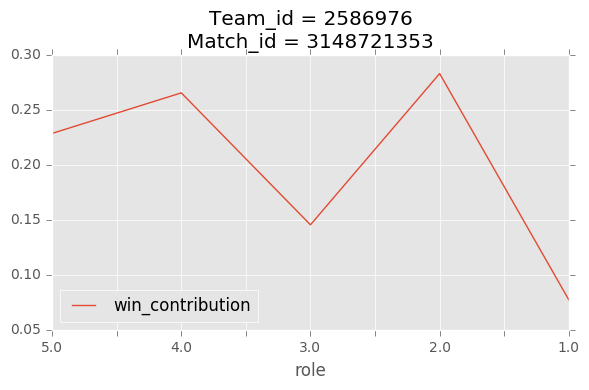

In [21]:
match_id = '3148721353'
team_id = '2586976'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
plot = example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)
fig = plot.get_figure()
plt.tight_layout()
fig.savefig(str(example.iloc[0,1]) + "_" + str(example.iloc[0,2]) + ".png", dpi = 400)

# OG vs VP
### match: https://www.dotabuff.com/matches/3149572447
### team1: https://www.dotabuff.com/esports/teams/2586976
### team2: https://www.dotabuff.com/esports/teams/1883502

## OG

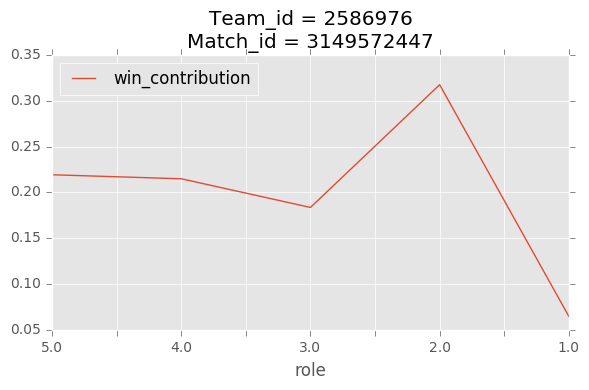

In [22]:
match_id = '3149572447'
team_id = '2586976'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
plot = example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)
fig = plot.get_figure()
plt.tight_layout()
fig.savefig(str(example.iloc[0,1]) + "_" + str(example.iloc[0,2]) + ".png", dpi = 400)

## VP

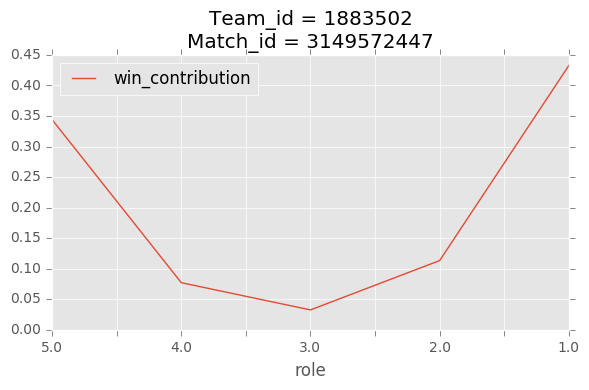

In [23]:
match_id = '3149572447'
team_id = '1883502'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
plot = example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)
fig = plot.get_figure()
plt.tight_layout()
fig.savefig(str(example.iloc[0,1]) + "_" + str(example.iloc[0,2]) + ".png", dpi = 400)

# Col vs EG
### match: https://www.dotabuff.com/matches/3033038349
### team1: https://www.dotabuff.com/esports/teams/3
### team2: https://www.dotabuff.com/esports/teams/39

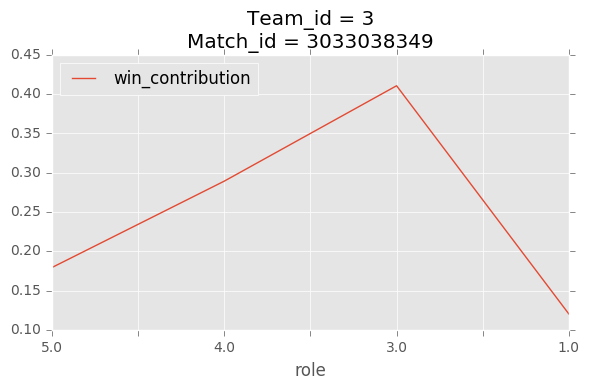

In [24]:
match_id = '3033038349'
team_id = '3'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
plot = example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)
fig = plot.get_figure()
plt.tight_layout()
fig.savefig(str(example.iloc[0,1]) + "_" + str(example.iloc[0,2]) + ".png", dpi = 400)

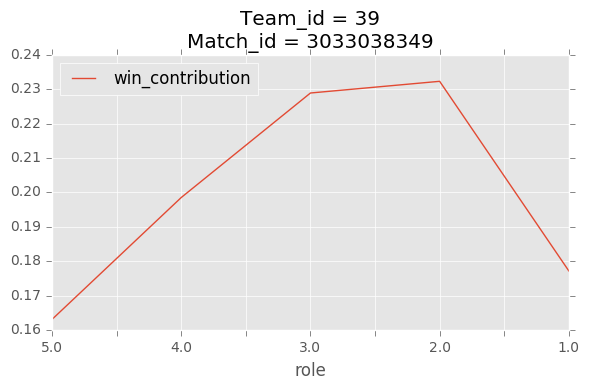

In [25]:
match_id = '3033038349'
team_id = '39'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
plot = example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)
fig = plot.get_figure()
plt.tight_layout()
fig.savefig(str(example.iloc[0,1]) + "_" + str(example.iloc[0,2]) + ".png", dpi = 400)